In [43]:
import numpy as np
import os
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datasets import load_from_disk
from TorchCRF import CRF

In [44]:
'''Reference: https://huggingface.co/datasets/rajpurkar/squad_v2'''
# from datasets import load_dataset

# ds = load_dataset("rajpurkar/squad_v2")
# ds.save_to_disk("squad_v2")

'Reference: https://huggingface.co/datasets/rajpurkar/squad_v2'

In [45]:
#load the presaved dataset
from datasets import load_from_disk
squad_v2 = load_from_disk("squad_v2")

In [46]:
print(squad_v2)

#printing the questions and answers for the same context
train_dataset = squad_v2["train"]
val_dataset = squad_v2["validation"]
print(train_dataset[0])

contexts = set()
for i in range(len(train_dataset)):
    contexts.add(train_dataset[i]["context"])
print(len(contexts))

train_dataset_filtered = train_dataset.filter(lambda x: len(x["answers"]["text"]) > 0)
val_dataset_filtered = val_dataset.filter(lambda x: len(x["answers"]["text"]) > 0)

print(f"Original training examples: {len(train_dataset)}")
print(f"Filtered training examples: {len(train_dataset_filtered)}")
print(f"Original validation examples: {len(val_dataset)}")
print(f"Filtered validation examples: {len(val_dataset_filtered)}")

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})
{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "C

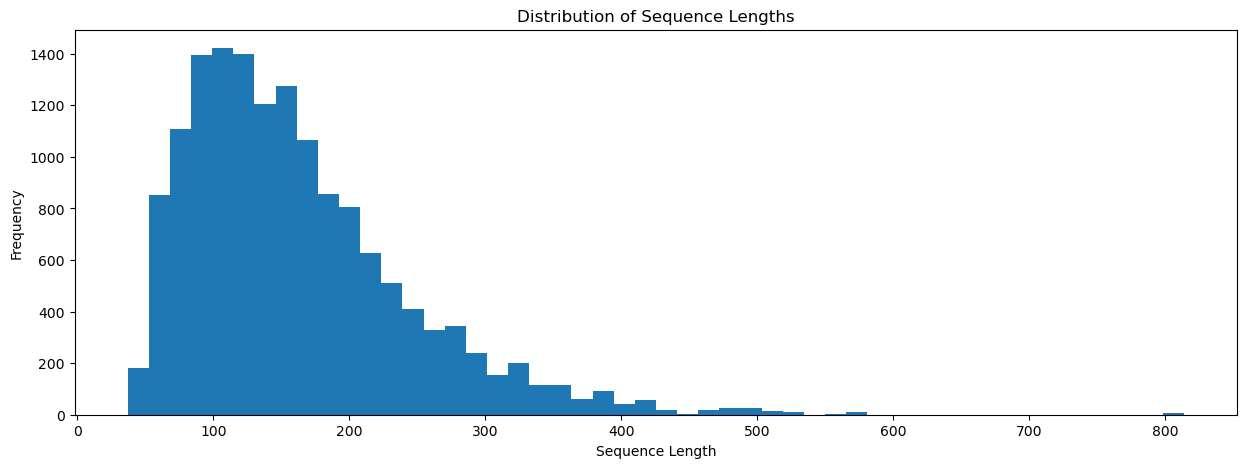

Map: 100%|██████████| 11873/11873 [00:03<00:00, 3741.88 examples/s]


In [47]:
#from assignment 
def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Convert to percentage

def preprocess_data(examples, tokenizer, max_length):
    '''
    Preprocesses the SQuAD v2 dataset examples for question answering task.
    
    Args:
        examples: Dictionary containing the raw examples with questions, contexts and answers
        tokenizer: Tokenizer to use for encoding the text
        max_length: Maximum sequence length for tokenization 
        
    Returns:
        tokenized: Dictionary containing the preprocessed features including:
            - input_ids: Token IDs for the combined question and context
            - attention_mask: Attention mask for valid tokens
            - start_positions: Token position where answer starts
            - end_positions: Token position where answer ends
    '''
    
    questions = [q.strip() for q in examples["question"]]
    contexts = [c.strip() for c in examples["context"]]
    
    #Tokenizing inputs
    tokenized = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")
    
    start_positions = []
    end_positions = []
    
    for i, offset in enumerate(offset_mapping):
        #get the sample index from the mapping
        sample_idx = sample_mapping[i]
        
        #get the answer for the sample
        answer = examples["answers"][sample_idx]
        start_char = answer["answer_start"][0] if answer["text"] else -1
        end_char = start_char + len(answer["text"][0]) if answer["text"] else -1
        
        #get sequence IDs to find context tokens
        sequence_ids = tokenized.sequence_ids(i)
        
        #find context boundaries
        idx = 0
        while idx < len(sequence_ids) and sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1
        
        #set answer positions
        if start_char == -1 or end_char == -1:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and not (offset[idx][0] <= start_char < offset[idx][1]):
                idx += 1
            start_positions.append(idx if idx <= context_end else 0)
            
            idx = context_end
            while idx >= context_start and not (offset[idx][0] <= end_char <= offset[idx][1]):
                idx -= 1
            end_positions.append(idx if idx >= context_start else 0)
    
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized

#initialize models and tokenizer
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

batch_size = 8
train_size = 15000

train_subset = train_dataset.select(range(train_size))

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

lengths = []
for example in train_subset:
    inputs = tokenizer(
        example["question"],
        example["context"],
        truncation=False,
        padding=False
    )
    lengths.append(len(inputs["input_ids"]))

padding_length = 300

plt.figure(figsize=(15,5))
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

train_encoded = train_subset.map(
    lambda x: preprocess_data(x, tokenizer, padding_length),
    batched=True,
    remove_columns=train_subset.column_names,
    batch_size=32 
)

val_encoded = val_dataset.map(
    lambda x: preprocess_data(x, tokenizer, padding_length),
    batched=True,
    remove_columns=val_dataset.column_names,
    batch_size=32  
)


In [48]:
class SpanBERTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
        self.bert.qa_outputs.weight.data.normal_(mean=0.0, std=0.02)
        self.bert.qa_outputs.bias.data.zero_()
        
    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )
        return outputs

class SpanBERTCRF(nn.Module):
    def __init__(self, hidden_size=768):
        super().__init__()
        self.bert = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
        self.qa_transforms = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 2)  #2 tags B and I
        )
        self.crf = CRF(2, batch_first=True)  #crf layer
        self.init_weights()
    
    def init_weights(self):
        for layer in self.qa_transforms.children():
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()
    
    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        outputs = self.bert.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = outputs.last_hidden_state  
        emissions = self.qa_transforms(sequence_output)  
        
        if start_positions is not None and end_positions is not None:
            batch_size, seq_len = input_ids.shape
            tags = torch.zeros((batch_size, seq_len), dtype=torch.long, device=input_ids.device)
            for i, (start, end) in enumerate(zip(start_positions, end_positions)):
                if start > 0 and end > 0:  #this is the case where answer exists
                    tags[i, start] = 1
                    tags[i, start+1:end+1] = 1
            
            loss = -self.crf(emissions, tags, mask=attention_mask.bool(), reduction='mean')  # loss
            
            return {
                "loss": loss,
                "start_logits": emissions[:, :, 0],  
                "end_logits": emissions[:, :, 1]     
            }
        
        else:
            decoded_tags = self.crf.decode(emissions, mask=attention_mask.bool())  # decode
            start_logits = emissions[:, :, 0]
            end_logits = emissions[:, :, 1]
            
            return {
                "start_logits": start_logits,
                "end_logits": end_logits,
                "decoded_tags": decoded_tags
            }

    def get_span_predictions(self, decoded_tags):
        batch_spans = []
        for sequence in decoded_tags:
            sequence = torch.tensor(sequence)  
            positions = torch.where(sequence == 1)[0]  #find tags
            
            if len(positions) > 0:
                start = positions[0].item()
                end = positions[-1].item()
                batch_spans.append((start, end))
            else:
                batch_spans.append((0, 0))  #no answer case
                
        return batch_spans

In [49]:
class QADataset(Dataset):
    def __init__(self, encoded_dataset, max_length): 
        self.encoded_dataset = encoded_dataset
        self.max_length = max_length
        
    def __len__(self):
        return len(self.encoded_dataset)
    
    def __getitem__(self, idx):
        item = self.encoded_dataset[idx]
        input_ids = item['input_ids'][:self.max_length]
        attention_mask = item['attention_mask'][:self.max_length]

        if len(input_ids) < self.max_length:
            padding_length = self.max_length - len(input_ids)
            input_ids = input_ids + [0] * padding_length
            attention_mask = attention_mask + [0] * padding_length
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'start_positions': torch.tensor(item['start_positions'], dtype=torch.long),
            'end_positions': torch.tensor(item['end_positions'], dtype=torch.long)
        }

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    start_positions = [item['start_positions'] for item in batch]
    end_positions = [item['end_positions'] for item in batch]
    
    # Pad sequences dynamically
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'start_positions': torch.stack(start_positions),
        'end_positions': torch.stack(end_positions),
    }

train_dataset = QADataset(train_encoded, padding_length)
val_dataset = QADataset(val_encoded, padding_length)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    pin_memory=True,
    collate_fn=collate_fn
)

def train_model(model, train_dataloader, val_dataloader, learning_rate, num_epochs, model_type):
    """
    Training function for both SpanBERT and SpanBERT-CRF
    Args:
        model: The model to train
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        learning_rate: Learning rate
        num_epochs: Number of epochs
        model_type: "base" for SpanBERT, "crf" for SpanBERT-CRF
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    em_scores = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        
        for batch in progress_bar:
            try:
                batch = {k: v.to(device) for k, v in batch.items()}
                
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    start_positions=batch["start_positions"],
                    end_positions=batch["end_positions"]
                )
                
                loss = outputs["loss"] if isinstance(outputs, dict) else outputs.loss
                total_train_loss += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        predictions = []
        references = []
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                try:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    
                    # Get loss
                    outputs = model(
                        input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        start_positions=batch["start_positions"],
                        end_positions=batch["end_positions"]
                    )
                    
                    loss = outputs["loss"] if isinstance(outputs, dict) else outputs.loss
                    total_val_loss += loss.item()
                    
                    # Get predictions based on model type
                    if model_type == "crf":
                        # CRF model prediction
                        pred_outputs = model(
                            input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"]
                        )
                        pred_spans = model.get_span_predictions(pred_outputs["decoded_tags"])
                        
                        # Convert predictions to text
                        for i, (start, end) in enumerate(pred_spans):
                            pred_text = tokenizer.decode(
                                batch["input_ids"][i][start:end+1],
                                skip_special_tokens=True
                            ) if end > start else ""
                            
                            ref_text = tokenizer.decode(
                                batch["input_ids"][i][batch["start_positions"][i]:batch["end_positions"][i]+1],
                                skip_special_tokens=True
                            )
                            predictions.append(pred_text)
                            references.append(ref_text)
                    
                    else:
                        # Base model prediction
                        start_logits = outputs.start_logits if not isinstance(outputs, dict) else outputs["start_logits"]
                        end_logits = outputs.end_logits if not isinstance(outputs, dict) else outputs["end_logits"]
                        
                        start_pred = torch.argmax(start_logits, dim=1)
                        end_pred = torch.argmax(end_logits, dim=1)
                        
                        # Convert predictions to text
                        for i in range(len(start_pred)):
                            pred_text = tokenizer.decode(
                                batch["input_ids"][i][start_pred[i]:end_pred[i]+1],
                                skip_special_tokens=True
                            )
                            ref_text = tokenizer.decode(
                                batch["input_ids"][i][batch["start_positions"][i]:batch["end_positions"][i]+1],
                                skip_special_tokens=True
                            )
                            predictions.append(pred_text)
                            references.append(ref_text)
                            
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate exact match score
        em_score = exact_match_score(predictions, references)
        em_scores.append(em_score)
        
        print(f"\nEpoch {epoch+1}:")
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average validation loss: {avg_val_loss:.4f}")
        print(f"Exact match score: {em_score:.2f}%\n")
    
    return train_losses, val_losses, em_scores

Training SpanBERT model


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cuda
Validation: 100%|██████████| 1814/1814 [01:47<00:00, 16.89it/s]

Epoch 1:
Average training loss: 2.582
Average validation loss: 1.897
Exact match score: 43.62
Validation: 100%|██████████| 1814/1814 [01:48<00:00, 16.75it/s]

Epoch 2:
Average training loss: 1.671
Average validation loss: 1.738
Exact match score: 51.97
Validation: 100%|██████████| 1814/1814 [01:48<00:00, 16.79it/s]

Epoch 3:
Average training loss: 0.9787
Average validation loss: 2.298
Exact match score: 46.46
Validation: 100%|██████████| 1814/1814 [01:48<00:00, 16.77it/s]

Epoch 4:
Average training loss: 0.7183
Average validation loss: 2.381
Exact match score: 50.04
Validation: 100%|██████████| 1814/1814 [01:47<00:00, 16.84it/s]

Epoch 5:
Average training loss: 0.6214
Average validation loss: 2.479
Exact match score: 52.95
Validation: 100%|██████████| 1814/1814 [01:48<00:00, 16.76it/s]

Epoch 6:
Average training loss: 0.5541
Average validation loss: 2.206
Exact match score: 52.14
Validation: 100%|█████

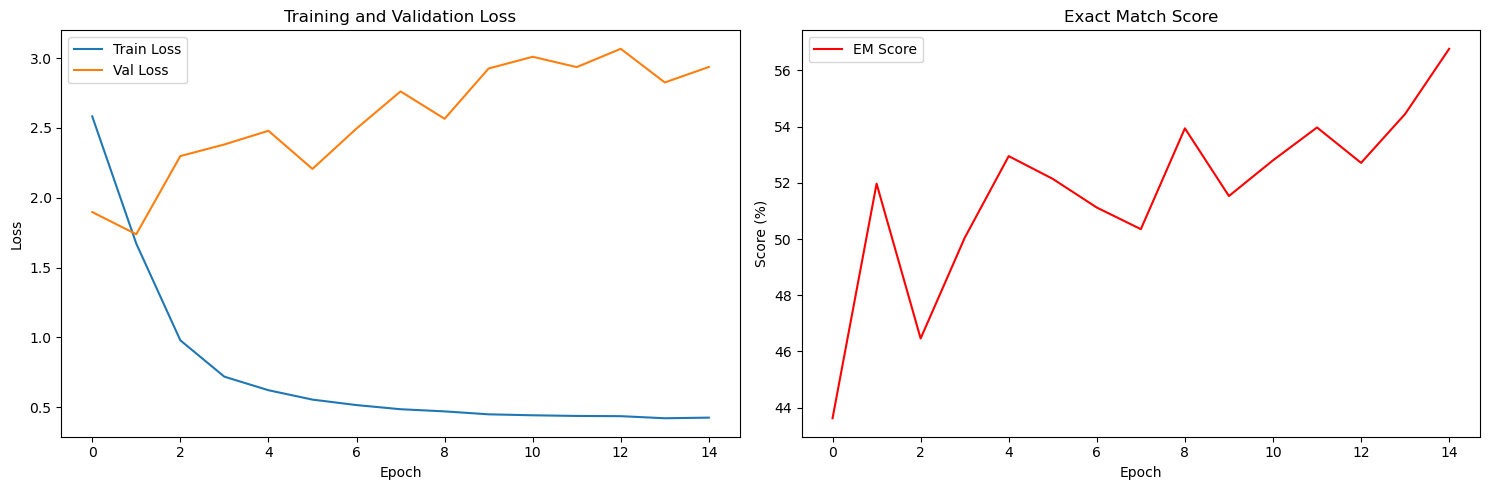

In [50]:
# Train SpanBERT model
print("Training SpanBERT model")
spanbert_model = SpanBERTModel()
train_losses, val_losses, em_scores = train_model(spanbert_model, train_dataloader, val_dataloader, learning_rate=2e-5, num_epochs=15, model_type="base")

# Plot results
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot EM scores
plt.subplot(1, 2, 2)
plt.plot(em_scores, label='EM Score', color='red')
plt.title('Exact Match Score')
plt.xlabel('Epoch') 
plt.ylabel('Score (%)')
plt.legend()

plt.tight_layout() 
plt.show()

Training SpanBERT-CRF model


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cuda
Validation: 100%|██████████| 1814/1814 [07:02<00:00,  4.29it/s]

Epoch 1:
Average training loss: 11.3853
Average validation loss: 6.5538
Exact match score: 55.40%
Validation: 100%|██████████| 1814/1814 [07:01<00:00,  4.31it/s]

Epoch 2:
Average training loss: 4.2567
Average validation loss: 5.2201
Exact match score: 58.02%
Validation: 100%|██████████| 1814/1814 [07:07<00:00,  4.24it/s]

Epoch 3:
Average training loss: 2.7388
Average validation loss: 5.2702
Exact match score: 57.06%
Validation: 100%|██████████| 1814/1814 [06:49<00:00,  4.43it/s]

Epoch 4:
Average training loss: 1.9948
Average validation loss: 5.9504
Exact match score: 61.01%
Validation: 100%|██████████| 1814/1814 [06:54<00:00,  4.37it/s]

Epoch 5:
Average training loss: 1.4937
Average validation loss: 6.1364
Exact match score: 60.72%
Validation: 100%|██████████| 1814/1814 [06:54<00:00,  4.37it/s]

Epoch 6:
Average training loss: 1.1797
Average validation loss: 5.7776
Exact match score: 58.04%
Validat

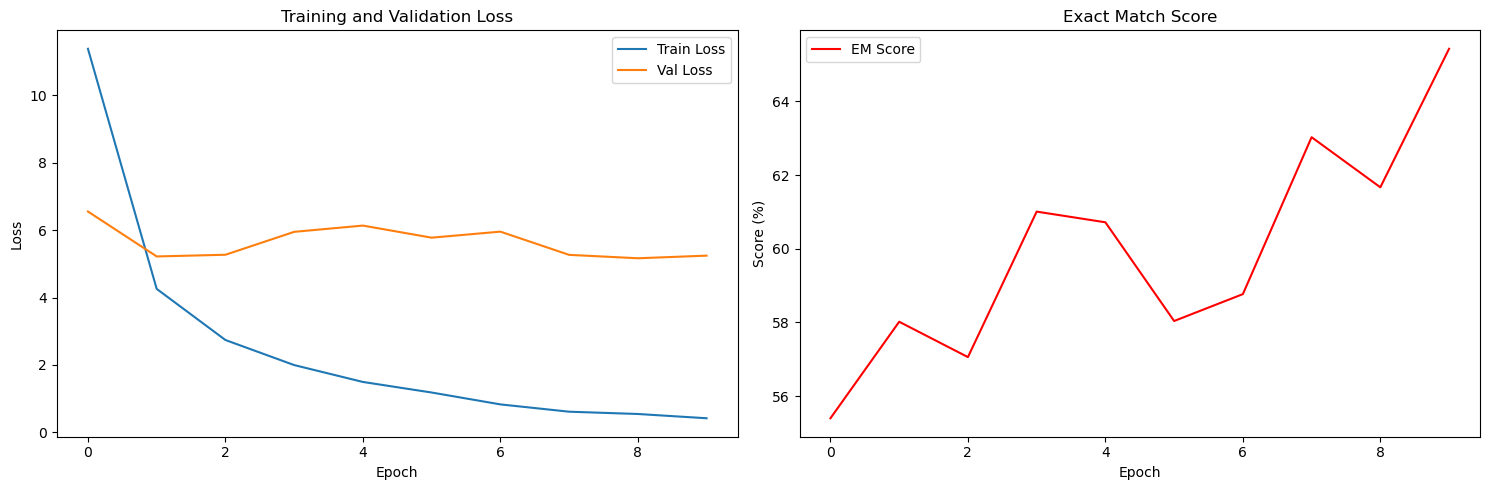

In [ ]:
torch.cuda.empty_cache()

# Initialize and train the model
print("Training SpanBERT-CRF model")
model = SpanBERTCRF()
train_losses, val_losses, em_scores = train_model(spanbert_model, train_dataloader, val_dataloader, learning_rate=2e-5, num_epochs=10, model_type="crf")

# Plot results
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot EM scores
plt.subplot(1, 2, 2)
plt.plot(em_scores, label='EM Score', color='red')
plt.title('Exact Match Score')
plt.xlabel('Epoch') 
plt.ylabel('Score (%)')
plt.legend()

plt.tight_layout() 
plt.show()